# Part 1: sentiment analysis

In [1]:
# -*- coding: utf-8 -*-
# goto https://github.com/n-lo/Tweets_analysis_tryout for other parts
%matplotlib inline

from __future__ import print_function
import pprint, datetime
import pandas as pd
import numpy as np
import gensim, re
from dateutil import parser
from ggplot import *

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 14, 10

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# e.g. logging.info("%i tweets found..." % len(df))

pp = pprint.PrettyPrinter(indent=4)

## Load in data

Dataset contains Tweets between 09-08-2016 and 22-08-2016.  

Load dataframe from hdf5 file (see db2df.ipynb for loading data from MongoDB databases to dataframe)

In [2]:
print("Load df from hdf5 file.")
hdf = pd.HDFStore('onp.h5')
df = hdf['df']
hdf.close()
print("%d Tweets loaded." % len(df))

Load df from hdf5 file.
8963 Tweets loaded.


Drop unused columns for this session (reduce memory usage)

In [3]:
df.drop(['favorited', 'possibly_sensitive', 'truncated', 'user_entities.description.urls', 
         'user_entities.url.urls', 'user_is_translator', 'contributors', 'coordinates',
         'entities', 'extended_entities', 'geo', 'in_reply_to_screen_name', 'in_reply_to_status_id',
         'in_reply_to_user_id', 'user_geo_enabled', 'user_verified', 'user_url',
         'user_protected', 'user_listed_count', 'user_has_extended_profile', 'quoted_status_id',
         'user_contributors_enabled', 'user_notifications'], 
        axis = 1, inplace = True)

In [4]:
df.columns

Index([u'_id', u'created_at', u'favorite_count', u'id', u'id_str',
       u'in_reply_to_status_id_str', u'in_reply_to_user_id_str',
       u'is_quote_status', u'lang', u'metadata', u'place', u'quoted_status',
       u'quoted_status_id_str', u'retweet_count', u'retweeted',
       u'retweeted_status', u'source', u'text', u'user', u'user_created_at',
       u'user_description', u'user_favourites_count',
       u'user_follow_request_sent', u'user_followers_count', u'user_following',
       u'user_friends_count', u'user_id', u'user_id_str',
       u'user_is_translation_enabled', u'user_lang', u'user_location',
       u'user_name', u'user_screen_name', u'user_statuses_count',
       u'user_time_zone', u'user_utc_offset'],
      dtype='object')

#### Note:
When the data set gets too big, can try selecting radom samples:  

from sklearn.cross_validation import train_test_split  
import random  
random.seed(1234)  
train, test = train_test_split(df, test_size = 0.5)  
del(df)  
df = train

## Quick look at the dataset

### 1. Check how many are retweets  
Retweets are marked with 'RT' at the beginning of the Tweeted content. Here we use Regex to search the contents.  

This data set contains 5983 retweets out of a total of 8963 tweets


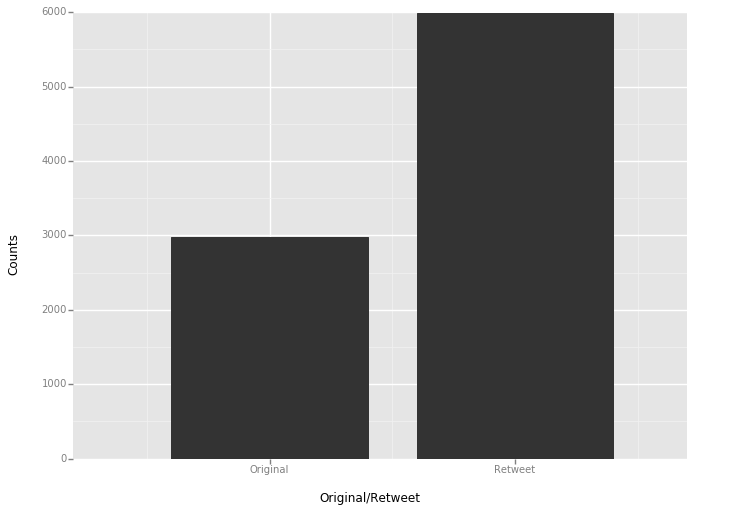

<ggplot: (56713981)>

In [5]:
df['retweet'] = 0

for index, row in df.iterrows():
    text = row['text']
    match = re.search(r'^\bRT\b', text)
    if match:
        df.set_value(index, 'retweet', 1)

print("This data set contains %i retweets out of a total of %i tweets" % 
      (sum(df['retweet']), len(df)))

ggplot(df, aes(x = 'retweet')) + geom_bar() + \
    scale_x_continuous(labels = ["Original", "Retweet"]) + xlab("Original/Retweet") + ylab("Counts")

### 2. Most retweeted tweets

In [16]:
df['my_retweet_cnt'] = 0
df['my_retweet_cnt'] = df.groupby('text').transform('count')

Top 10% retweets:

In [17]:
df[df['my_retweet_cnt'] >= np.percentile(df['my_retweet_cnt'], 90)]['text'].value_counts()

RT @Kon__K: Time I reshare 2015 photo of @WilsonSecurity staff from #Nauru with  Pauline #Hanson at white supremacist rally. https://t.co/P…        591
RT @vanbadham: Australian Nazi Ross "The Skull" May objected to me posting photos of him &amp; Pauline Hanson with this profile picture https:/…    371
Name: text, dtype: int64

### 3. Count number of tweets by each user

In [18]:
df['tweets_cnt'] = 0
df['tweets_cnt'] = df.groupby('user_id').transform('count')

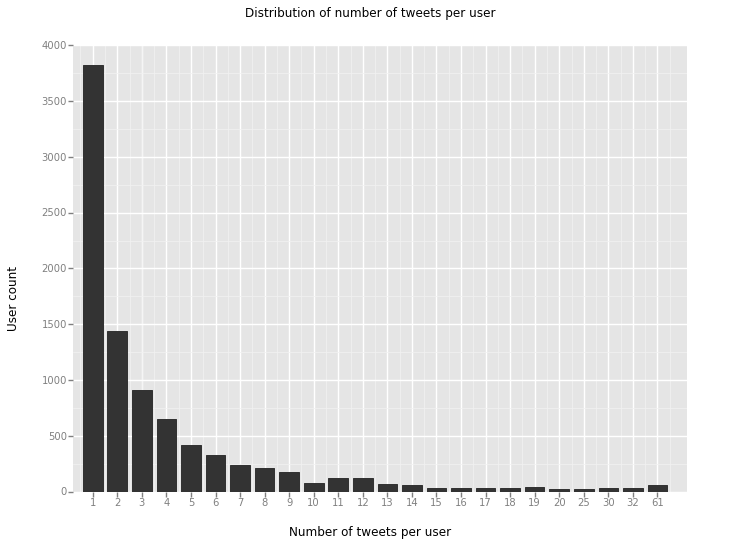

<ggplot: (17572836)>

In [21]:
ggplot(df, aes(x='tweets_cnt')) + geom_bar() + \
    ggtitle("Distribution of number of tweets per user") + xlab("Number of tweets per user") +\
    ylab("User count")

#### Subset high tweets_cnt users

In [22]:
df_active_twitters = df[df['tweets_cnt'] >= np.percentile(df['tweets_cnt'], 95)]
print("%d users in the top 5 per cent tweets count." % 
      len(df_active_twitters['user_id'].value_counts()))

24 users in the top 5 per cent tweets count.


In [28]:
df_active_twitters = df_active_twitters.drop_duplicates(subset='user_id', keep='last')
print('Information on the top 5 per cent most active twitter users.')
df_active_twitters[['user_description', 'user_created_at', 
                    'user_location', 'tweets_cnt']]
#df_active_twitters.ix[:, 'user_created_at':'user_statuses_count'].transpose()

Information on the top 5 per cent most active twitter users.


,user_description,user_created_at,user_location,tweets_cnt
3908,Say NO to RACISM,Fri Aug 12 06:22:32 +0000 2016,"Sydney, New South Wales",17
5393,"Experimental, marine ecologist studying ocean ...",Thu Apr 25 21:01:18 +0000 2013,"Brisbane, Queensland",13
6414,,Wed Feb 16 09:14:43 +0000 2011,Sydney,16
7246,,Fri Jun 01 10:32:21 +0000 2012,Adelaide South Australia,20
7348,In space no one can hear you complain about th...,Tue Sep 14 10:03:38 +0000 2010,Brisbane Australia,14
7717,,Thu Jan 09 14:41:53 +0000 2014,Australia,13
7821,Glad you're seated it's a long story. Too long...,Fri Jan 28 00:57:17 +0000 2011,Australia,18
7891,,Sat May 31 14:58:58 +0000 2014,,13
7910,Artist. Learning Ukulele slowly. Leftie. Athei...,Sun Nov 03 21:47:50 +0000 2013,Blue Mountains,19
8024,,Sun Mar 22 01:29:02 +0000 2015,,14


In [29]:
print("%d unique twitter users in this data set." % len(df['user_id'].unique()))

5276 unique twitter users in this data set.


## Sentiment analysis

Now try the sentiment analysis with AFINN valence rated words from  
http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6010  

To import:  
afinn = 
   dict(map(lambda (k,v): (k,int(v)), [ line.split('\t') for line in open("AFINN-111.txt") ]))  
afinn["Good".lower()]  
> 3  

sum(map(lambda word: afinn.get(word, 0), "Rainy day but still in a good mood".lower().split()))  
> 2  

### 1. Calculate sentiment scores

#### Import positive and negative words

In [30]:
wd_file = "AFINN-111.txt"

afinn = dict(map(lambda (k,v): (k,int(v)), [ line.split('\t') for line in open(wd_file) ]))

#### Get a list of stopwords

In [31]:
sw = set(gensim.parsing.preprocessing.STOPWORDS)
my_sw = ['http', 'https', 'RT']

#### Functions to remove URLs, tokenize text

In [32]:
def remove_url(text):
    text = text.lower()
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"@+", " ", text)
    return text

In [33]:
def split_wd(text, stopwords=sw):
    new_sw = set(sw)
    new_sw |= set(my_sw)
    return [wd
            for wd in gensim.utils.tokenize(text, lower=True)
            if wd not in new_sw and len(wd) > 3]

#### Calculate the sentiment score

In [34]:
# for each tweets, get the sentiment score
df['sentiment_afinn'] = 0

#n = 0
for index, row in df.iterrows():
    text = row['text']
    text = remove_url(text)
    tokens = split_wd(text, sw)

    score = sum(map(lambda word: afinn.get(word, 0), tokens))
    df.set_value(index, 'sentiment_afinn', score)

#    n += 1
#    if n >= 10:
#        break

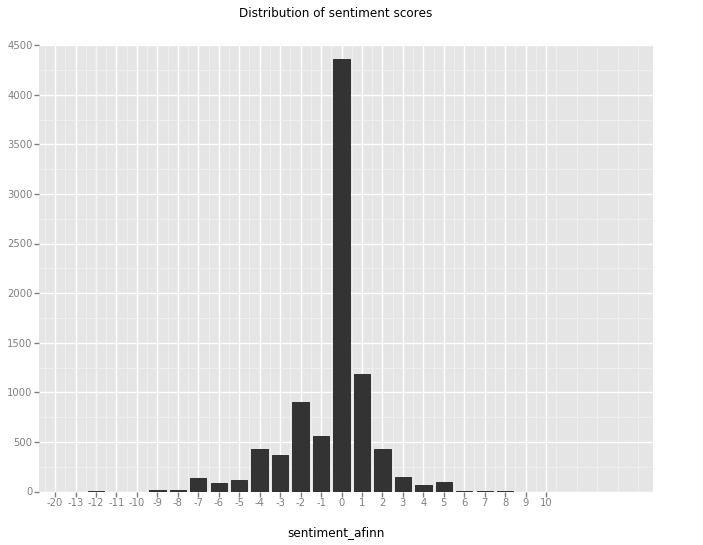

<ggplot: (35405014)>


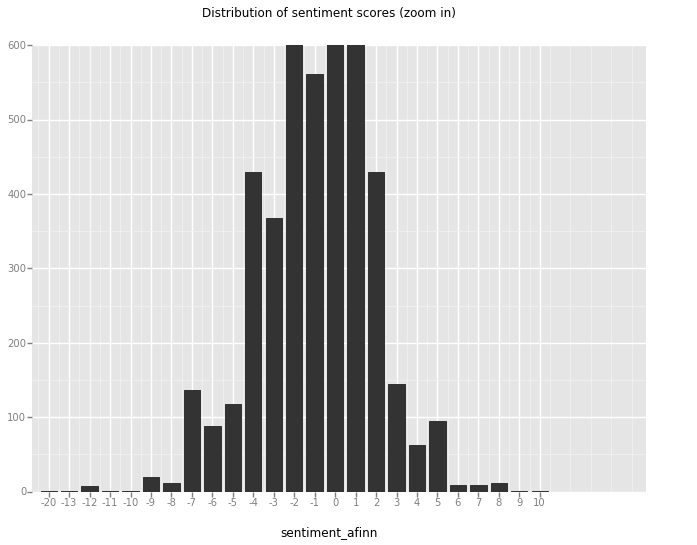

<ggplot: (54131993)>


In [35]:
p1 = ggplot(df, aes(x = 'sentiment_afinn')) + geom_bar() + ggtitle("Distribution of sentiment scores")
    
p2 = ggplot(df, aes(x = 'sentiment_afinn')) + geom_bar() + \
     scale_y_continuous(limits = (0,600)) + ggtitle("Distribution of sentiment scores (zoom in)")
    
print(p1)
print(p2)

#### Save to dataframe

In [ ]:
print("Writing dataframe to disk...")
hdf = pd.HDFStore("onp_sentiment.h5")
hdf['df'] = df
hdf.close()

### 2. Sentiment changes over time

#### Function to remove time of the day

In [37]:
def remove_time(t):
    return datetime.datetime(t.year, t.month, t.day)

#### Total sentiment score by date

Add a new tweet's date column with only year, month, day, no time

In [38]:
df['date'] = df['created_at'].apply(parser.parse) # convert string to date object
df['date'] = df['date'].apply(remove_time)

In [39]:
by_date_afinn = pd.DataFrame(df.groupby('date')['sentiment_afinn'].sum())
by_date_afinn['tweets'] = df.groupby('date')['text'].count()
by_date_afinn['pos cnt'] = \
    df[df['sentiment_afinn'] > 0].groupby('date')['sentiment_afinn'].count()
by_date_afinn['neg cnt'] = \
    df[df['sentiment_afinn'] < 0].groupby('date')['sentiment_afinn'].count()
#by_date_afinn['date'] = pd.to_datetime(by_date_afinn.index)
by_date_afinn['date'] = by_date_afinn.index.day

by_date_afinn = by_date_afinn.reset_index(drop=True)

In [40]:
by_date_afinn

,sentiment_afinn,tweets,pos cnt,neg cnt,date
0,2,2,1,NaN,9
1,-54,199,35,59.0,10
2,100,295,68,57.0,11
3,-48,559,81,78.0,12
4,-400,458,53,219.0,13
5,-202,831,394,237.0,14
6,-1763,3451,800,1063.0,15
7,-1231,1527,254,515.0,16
8,-80,479,84,89.0,17
9,-210,502,69,111.0,18


#### Simple bar plot

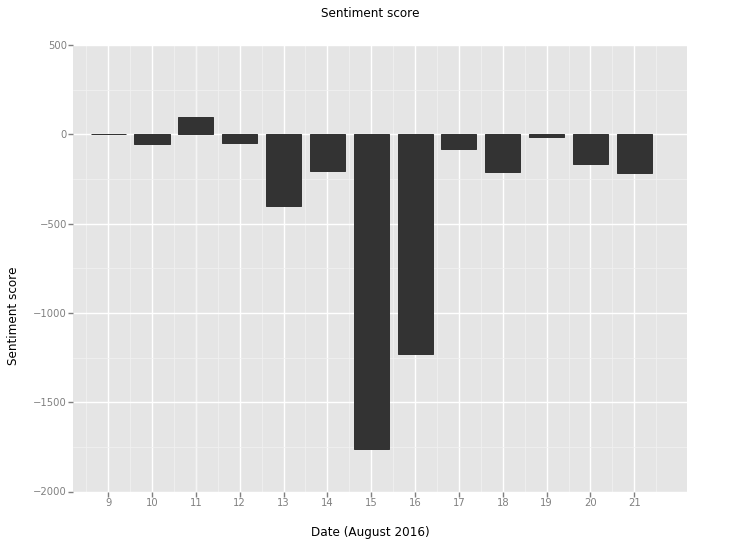

<ggplot: (18037729)>


In [41]:
p1 = ggplot(by_date_afinn, aes(x='date', weight='sentiment_afinn')) + geom_bar() + \
    xlab("Date (August 2016)") + ylab("Sentiment score") + ggtitle("Sentiment score")
    
print(p1)

#### Box plot

In [43]:
def return_day(t):
    return t.day

df['day'] = df['date'].apply(return_day)

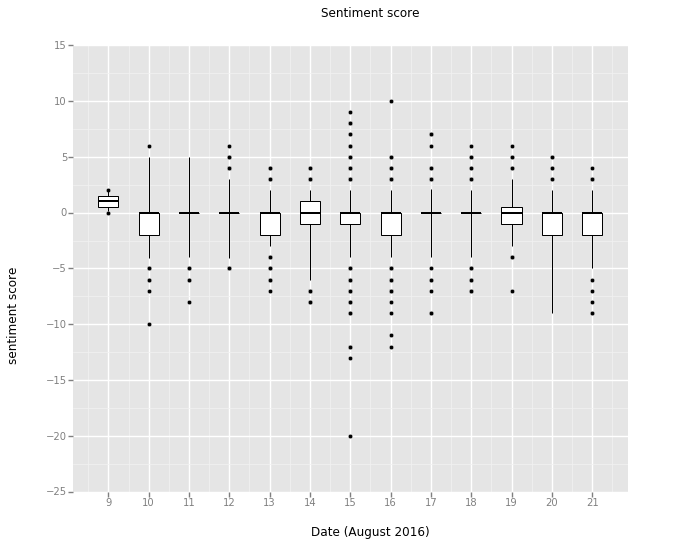

<ggplot: (51170438)>

In [44]:
ggplot(df, aes(x='day', y='sentiment_afinn', group = 'day')) + \
    geom_boxplot() + ylab("sentiment score") + xlab("Date (August 2016)") + \
    ggtitle("Sentiment score")

### Notes
Tweets are mostly negative, except on the 11th August where the total score is positive.  
On the 10th, 13th, 15th, 16th, 20th, 21st, the first, second, and third quartile (IQR) scores negative sentiment.  

The following codes will print out some of those tweets.  

In [ ]:
pos_day_tweets = df.loc[(df['date'] == '2016-08-11')]
print("Number of tweets: %d" % len(pos_day_tweets))
pos_day_tweets[pos_day_tweets['sentiment_afinn'] > 0]['text'].value_counts()

In [ ]:
pos_day_tweets = df.loc[(df['date'] == '2016-08-13')]
print("Number of tweets: %d" % len(pos_day_tweets))
pos_day_tweets[pos_day_tweets['sentiment_afinn'] > 0]['text'].value_counts()

In [ ]:
pos_day_tweets = df.loc[(df['date'] == '2016-08-15')]
print("Number of tweets: %d" % len(pos_day_tweets))
pos_day_tweets[pos_day_tweets['sentiment_afinn'] > 0]['text'].value_counts()

#### Todo:

Add in sarcastic detection later on.